In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import hython

import os
import xarray as xr
import random 
import numpy as np
from pathlib import Path 
import glob

from sklearn.metrics import mean_squared_error

import torch
from torch import nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset, random_split, Dataset

# Eurac utils
from hython.preprocess import preprocess, apply_normalization
from hython.models.lstm import CustomLSTM, CudnnLSTM
from hython.metrics import RMSELoss
from hython.datasets.datasets import LSTMDataset
from hython.train_val import train_val
from hython.sampler import RegularIntervalSampler
from hython.viz import plot_sampler
from hython.utils import missing_location_idx, reconstruct_from_missing

# visualize 
import matplotlib.pyplot as plt
import geopandas as gpd
from cartopy import crs as ccrs

import warnings
warnings.filterwarnings("ignore")

ERROR 1: PROJ: proj_create_from_database: Open of /home/iferrario/.local/miniforge/envs/emulator/share/proj failed


In [3]:
# import sys
# sys.path.append('/home/iferrario/dev/differentiable_modelling/tsai/model_code/')
# from hydroDL.model import rnn, crit, train

In [4]:
def set_seed(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True

set_seed(2023)

## Overview


Before training we are sampling the grid domain and removing the missing values. 

The operation of reshaping&sampling and missing removal are invertible, meaning it is always possible to go back to the parent grid.

**Missing values**: the last step of the workflow removes missing values (np.nan). Missing here is considered as any values that should not be used in model training/validation. For example if there is a reason to remove lakes from the training, we should set lakes to missing (i.e., np.nan). 

![sampling](assets/grid_sampling.png)



**Train/validation approach**:
There are three types of validation: The more common is type a), but here we are more interested in b) and c), as the goal is regionalizaiton of parameters.

![sampling](assets/validation_strategy.png)


**Normalization**:

Normalization helps the algorithm reaching a miminum, decreasing computation time. It is not straightforward how to normalize training and validation datasets in case of validation approach b) and c) 

**Mini-batch**: 
Randomly selecting gridcells and time sequence chunks.

In [51]:
## user settings

domain = "alps" # "alps"

timeslice = slice("2016-01-01","2020-12-31")


dynamic_names = ["precip", "pet", "temp"]
static_names = [ 'M', 'thetaS', 'RootingDepth', 'Kext', 'Sl', 'Swood', 'TT', 'KsatHorFrac'] 
target_names = [ "vwc"] #  ,"actevap" ] # "q_river"]




In [6]:
if domain == "alps":
    ipath = Path('/mnt/CEPH_PROJECTS/InterTwin/Wflow/full_domain/alps1km')
    dyn_vars_ds = xr.open_dataset(ipath / 'inmaps_eobs_eobsd_makkink_86400_2015_2019.nc', decode_coords='all',chunks= {"time":100})
    static_params_ds = xr.open_dataset(ipath / "staticmaps.nc", decode_coords='all', chunks= {"time":100}).sel(layer=1)
    target_ds = xr.open_dataset(ipath / "run_default/output.nc", decode_coords='all', chunks= {"time":100}).sel(layer=1).isel(lat=slice(None, None, -1))
    target_ds.dims,dyn_vars_ds.dims, static_params_ds.dims
if domain == "adige":
    glob.glob('/mnt/CEPH_PROJECTS/InterTwin/Surrogate_Model/Train Model/Deltras Data')
    dyn_vars_ds = xr.open_dataset('/mnt/CEPH_PROJECTS/InterTwin/Surrogate_Model/Train Model/Deltras Data/Dynamic_Data_2000_2015.nc',decode_coords='all', chunks= {"time":100})#.to_dataset(dim='variable')
    static_params_ds = xr.open_dataset('/mnt/CEPH_PROJECTS/InterTwin/Surrogate_Model/Train Model/Deltras Data/staticmaps.nc',decode_coords='all', chunks= {"time":100}).sel(layer=1)#.to_dataset(dim='variable')
    target_ds = xr.open_dataset('/mnt/CEPH_PROJECTS/InterTwin/Surrogate_Model/Train Model/Deltras Data/Target_train_et_sm_2000_2015.nc',decode_coords='all', chunks= {"time":100}).isel(lat=slice(None, None, -1))
    dyn_vars_ds.dims, static_params_ds.dims, target_ds.dims
if domain == "demo":
    dyn_vars_ds = xr.open_dataset('../data/dyn_vars.nc',decode_coords='all', chunks= {"time":100})#.to_dataset(dim='variable')
    static_params_ds = xr.open_dataset('../data/staticmaps_calibrated_parameters.nc',decode_coords='all', chunks= {"time":100}).sel(layer=1)#.to_dataset(dim='variable')
    target_ds = xr.open_dataset('../data/soil_moisture_2019.nc',decode_coords='all', chunks= {"time":100}).isel(lat=slice(None, None, -1))

    target_ds = target_ds.rename_vars({"vwc_percroot":"vwc"})
    dyn_vars_ds.dims, static_params_ds.dims, target_ds.dims

In [7]:
target_ds.vwc.shape, dyn_vars_ds.data_vars, static_params_ds

((1825, 689, 1177),
 Data variables:
     precip       (time, lat, lon) float32 dask.array<chunksize=(100, 689, 1177), meta=np.ndarray>
     pet          (time, lat, lon) float32 dask.array<chunksize=(100, 689, 1177), meta=np.ndarray>
     temp         (time, lat, lon) float32 dask.array<chunksize=(100, 689, 1177), meta=np.ndarray>
     spatial_ref  int64 ...,
 <xarray.Dataset>
 Dimensions:                  (lat: 689, lon: 1177, time: 12)
 Coordinates:
   * lat                      (lat) float64 50.03 50.02 50.01 ... 43.73 43.72
   * lon                      (lon) float64 5.079 5.088 5.098 ... 15.85 15.86
   * time                     (time) int64 1 2 3 4 5 6 7 8 9 10 11 12
     layer                    int64 1
     spatial_ref              int64 ...
 Data variables: (12/80)
     x_out                    (lat, lon) float64 dask.array<chunksize=(689, 1177), meta=np.ndarray>
     y_out                    (lat, lon) float64 dask.array<chunksize=(689, 1177), meta=np.ndarray>
     idx_out  

## Preparation

In [52]:
if timeslice:
    dyn_vars_ds = dyn_vars_ds.sel(time=timeslice)
    target_ds = target_ds.sel(time=timeslice)
    target_ds.dims,dyn_vars_ds.dims

In [9]:
dim_space = list(dyn_vars_ds.dims.values())[1:] # lon, lat
dim_time = list(dyn_vars_ds.dims.values())[0] # tim
dim_space, dim_time

([1177, 689], 1826)

In [ ]:
intervals = (10, 10)
train_origin = (0, 0)
valid_origin =  (3, 3)
test_origin =  (9, 9)

remove_lakes = False
compute = False
save = False

### Preprocess

In [11]:
# mask lakes

if remove_lakes:
    mask_lakes = (target_ds.mean(dim = "time")["actevap"] == 0).astype(np.bool_)
    target_ds = target_ds.where(~mask_lakes, np.nan)
    dyn_vars_ds = dyn_vars_ds.where(~mask_lakes, np.nan)
    static_params_ds = static_params_ds.where(~mask_lakes, np.nan)

if domain == "demo":
    targets_nan = (np.isnan(target_ds.mean(dim="time"))).astype(np.bool_)
    
    target_ds = target_ds.where(~targets_nan, np.nan)
    static_params_ds = static_params_ds.where(~targets_nan.vwc, np.nan)

In [ ]:
if compute: 
    Xd, Xs, Y, dims, meta = preprocess(dyn_vars_ds, 
                       static_params_ds, 
                       target_ds, 
                       dynamic_name = dynamic_names,
                       static_name = static_names, 
                       target_name = target_names, 
                       # sampler = RegularIntervalSampler(
                       #              intervals = intervals,
                       #              origin = train_origin
                       # )
                       )
    Xd_valid, Xs_valid, Y_valid, dims_valid, meta_valid = preprocess(dyn_vars_ds, 
                       static_params_ds, 
                       target_ds, 
                       dynamic_name = dynamic_names,
                       static_name = static_names, 
                       target_name = target_names, 
                       # sampler = RegularIntervalSampler(
                       #     intervals = intervals,
                       #     origin = valid_origin),
                       )
else:
    loaded = np.load(f'/mnt/CEPH_PROJECTS/InterTwin/Surrogate_Model/temp/grid_{intervals[0]}_{train_origin[0]}_{valid_origin[0]}.npz',
                    allow_pickle=True)
    for ff in loaded.files:
        print(ff)
        if "dims" in ff:
            exec(f"{ff}=loaded['{ff}'].tolist()")
        else:
            exec(f"{ff}=loaded['{ff}']")

In [19]:
if save:
    np.savez_compressed(f'/mnt/CEPH_PROJECTS/InterTwin/Surrogate_Model/temp/grid_{intervals[0]}_{train_origin[0]}_{valid_origin[0]}'
                    , Xd=Xd, Xs=Xs, Y=Y, dims=dims, Xd_valid=Xd_valid, Xs_valid=Xs_valid,
                       Y_valid=Y_valid, dims_valid=dims_valid, meta=meta, meta_valid=meta_valid)

In [20]:
# Xd_test, Xs_test, Y_test, dims_test = preprocess(dyn_vars_ds, 
#                        static_params_ds, 
#                        target_ds, 
#                        dynamic_name = dynamic_names,
#                        static_name = static_names, 
#                        target_name = target_names, 
#                        sampler = Sampler(intervals = intervals,
#                                          origin = test_origin)
#                        )

In [16]:
if (Y < 0).any():
    print("found negative values")
    Y = np.where(Y < 0, 0, Y)

found negative values


In [17]:
Y = Y[:,:,[0]]
Y_valid = Y_valid[:,:,[0]]

NameError: name 'Y_valid' is not defined

In [18]:
Y.shape,Xs.shape, dims

NameError: name 'dims' is not defined

### Remove missing

In [19]:
# find indices of missing values
idx = missing_location_idx(Xs)

In [ ]:
# find indices of missing values
idx_valid = missing_location_idx(Xs_valid)
#plt.imshow(idx_valid.reshape(*dims["orig"][:2]))

In [20]:
Xd_clean = Xd[~idx]
Xs_clean = Xs[~idx]
Y_clean = Y[~idx]

In [ ]:
Xd_valid_clean = Xd_valid[~idx_valid]
Xs_valid_clean = Xs_valid[~idx_valid]
Y_valid_clean = Y_valid[~idx_valid]

In [21]:
Xd.shape, Xd_clean.shape, Xs_clean.shape, Y_clean.shape

((810953, 1461, 3), (372069, 1461, 3), (372069, 8), (372069, 1461, 1))

In [22]:
np.isnan(Xd_clean).any(), np.isnan(Xs_clean).any(), np.isnan(Y_clean).any(),np.isnan(Xd_valid_clean).any(), np.isnan(Xs_valid_clean).any(), np.isnan(Y_valid_clean).any()

NameError: name 'Xd_valid_clean' is not defined

In [116]:
Xd_clean.shape, Xs_valid_clean.shape

((372069, 1461, 3), (3722, 8))

### Normalization

In [23]:
Xd_clean, d_m, d_std = apply_normalization(Xd_clean, type = "spacetime", how ='standard')
Xs_clean, s_m, s_std = apply_normalization(Xs_clean, type = "space", how ='standard')

In [24]:
Y_clean, y_m, y_std = apply_normalization(Y_clean, type = "spacetime", how ='standard')

In [119]:
s_std.shape,d_std.shape

((8,), (3,))

In [120]:
Xd_valid_clean = apply_normalization(Xd_valid_clean, type = "spacetime", how ='standard', m = d_m, std = d_std)
Xs_valid_clean = apply_normalization(Xs_valid_clean, type = "space", how ='standard', m = s_m, std = s_std)

In [34]:
#Y_valid_clean = apply_normalization(Y_valid_clean, type = "spacetime", how ='standard', m = y_m, std = y_std)

In [35]:
np.isnan(Xd_clean).any(), np.isnan(Xs_clean).any(), np.isnan(Y_clean).any(),np.isnan(Xd_valid_clean).any(), np.isnan(Xs_valid_clean).any(), np.isnan(Y_valid_clean).any()

(False, False, False, False, False, False)

In [36]:
#plt.imshow(reconstruct_from_missing(Xs_clean, Xs.shape, idx)[:,2].reshape(*dims["sampled_dims"][:2]))
#plt.colorbar()

In [25]:
Xs_clean = torch.Tensor(Xs_clean)
Xd_clean = torch.Tensor(Xd_clean)
Y_clean = torch.Tensor(Y_clean)

In [26]:
Xs_valid_clean = torch.Tensor(Xs_valid_clean)
Xd_valid_clean = torch.Tensor(Xd_valid_clean)

Y_valid_clean = torch.Tensor(Y_valid_clean)

NameError: name 'Xs_valid_clean' is not defined

### Preparing data loader

In [27]:
nx = Xd.shape[-1] + Xs.shape[-1]
ny = Y.shape[-1]
nx, ny

(11, 1)

In [28]:
spatial_batch_size =  256 # int(512 / 4)
temporal_sampling_size = 120
seq_length = 60

In [29]:
train_dataset = LSTMDataset(Xd_clean, Y_clean, Xs_clean)

In [125]:
val_dataset = LSTMDataset(Xd_valid_clean, Y_valid_clean, Xs_valid_clean)

In [30]:
# PyTorch DataLoader
#data_loader = DataLoader(dataset, batch_size=spatial_batch_size, shuffle=False)
train_loader = DataLoader(train_dataset, batch_size=spatial_batch_size, shuffle=True)

In [ ]:
val_loader = DataLoader(val_dataset, batch_size=spatial_batch_size, shuffle=False)

In [31]:
# Invistigate the dataset 
for x1, x2, y in train_loader:
    print(x1.shape, x1.dtype)
    print(x2.shape, x2.dtype)
    print(y.shape, y.dtype)
    break

torch.Size([256, 1461, 3]) torch.float32
torch.Size([256, 8]) torch.float32
torch.Size([256, 1461, 1]) torch.float32


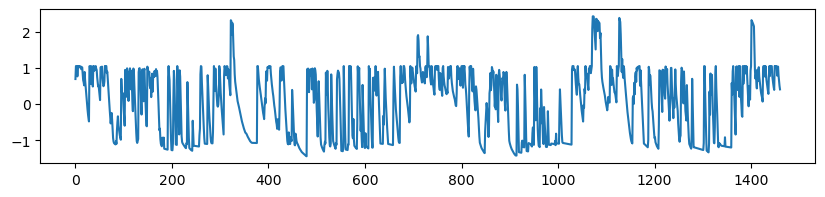

In [32]:
plt.figure(figsize= (10, 2))
plt.plot(y[1, :, 0])

### Setting up model

In [33]:
hidden_size = 64

model_params={
    "input_size": 3, #number of dynamic predictors - user_input
    "hidden_size": hidden_size, # user_input
    "output_size": Y.shape[-1], # number_target - user_input
    "number_static_predictors": len(static_names), #number of static parameters - user_input 

}

## The used device for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_params

{'input_size': 3,
 'hidden_size': 64,
 'output_size': 1,
 'number_static_predictors': 8}

In [34]:
model = CustomLSTM(model_params)
#model = CudnnLstmModel(nx = nx, ny =  ny, hiddenSize =  hidden_size)
model = model.to(device)
model

CustomLSTM(
  (fc0): Linear(in_features=11, out_features=64, bias=True)
  (lstm): LSTM(64, 64, batch_first=True)
  (fc1): Linear(in_features=64, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)

In [35]:
set_seed(2023)

def mse_metric(output, target):
    metric_epoch = mean_squared_error(output, target, squared=True)
    return metric_epoch

# Training and validation 
path2models= "./checkpoints" #./output/kaggle/working/AI4EO/models
if not os.path.exists(path2models):
    os.mkdir(path2models)
    
    
## Where to save the trained models weights 
## Set the optimization algorithms and learning rate
opt = optim.Adam(model.parameters(), lr=1e-2)

## Set the loss function
loss_fn = nn.MSELoss()

## Set the metric function - here using the same loss function 
metric_fn = mse_metric #nn.MSELoss()

## Set the learning rate scheduler
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=10)

In [39]:

epochs = 10

## Set the training parameters
params_train={
    "num_epochs": epochs,
    "temporal_sampling_size": temporal_sampling_size,
    "seq_length": seq_length,
    "ts_range": Y.shape[1],
    "optimizer": opt,
    "loss_func": loss_fn,
    "metric_func": metric_fn,
    "train_dl": train_loader, 
    #"val_dl": val_loader,
    "lr_scheduler": lr_scheduler,
    "path2weights": f"{path2models}/weights.pt",
    "device":device

}


type(model)

hython.models.lstm.CustomLSTM

In [40]:
model

CustomLSTM(
  (fc0): Linear(in_features=11, out_features=64, bias=True)
  (lstm): LSTM(64, 64, batch_first=True)
  (fc1): Linear(in_features=64, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)

## Running

### Soil Moisture + ET

In [50]:
#lossFun_PF = crit.RmseLoss()
#model = train.trainModel(
#    model, 
#    Xd, # gridcell x time x forcings
#    Y, # gridcell x time x out
#    Xs, # gridcell x VICpar
#    lossFun_PF, 
#    nEpoch=params_train["num_epochs"], 
#    miniBatch=[100, 60], 
#    saveEpoch=50, 
#    saveFolder="./")

In [348]:
model, sm_loss_history ,sm_metric_history = train_val(model, params_train)

Epoch 0/9, current lr=0.01
Copied best model weights!
train loss: 169.7716064453125, train metric: 169.77174377441406
val loss: 137.4759979248047, val metric: 137.4760284423828
----------
Epoch 1/9, current lr=0.01
Copied best model weights!
train loss: 89.7108383178711, train metric: 89.71082305908203
val loss: 113.12606811523438, val metric: 113.12603759765625
----------
Epoch 2/9, current lr=0.01
Copied best model weights!
train loss: 85.62263488769531, train metric: 85.62262725830078
val loss: 106.5521240234375, val metric: 106.55210876464844
----------
Epoch 3/9, current lr=0.01
Copied best model weights!
train loss: 80.52176666259766, train metric: 80.52179718017578
val loss: 100.10823059082031, val metric: 100.1082763671875
----------
Epoch 4/9, current lr=0.01
train loss: 86.93022918701172, train metric: 86.93021392822266
val loss: 111.13336944580078, val metric: 111.13341522216797
----------
Epoch 5/9, current lr=0.01
train loss: 84.26203918457031, train metric: 84.26203155517

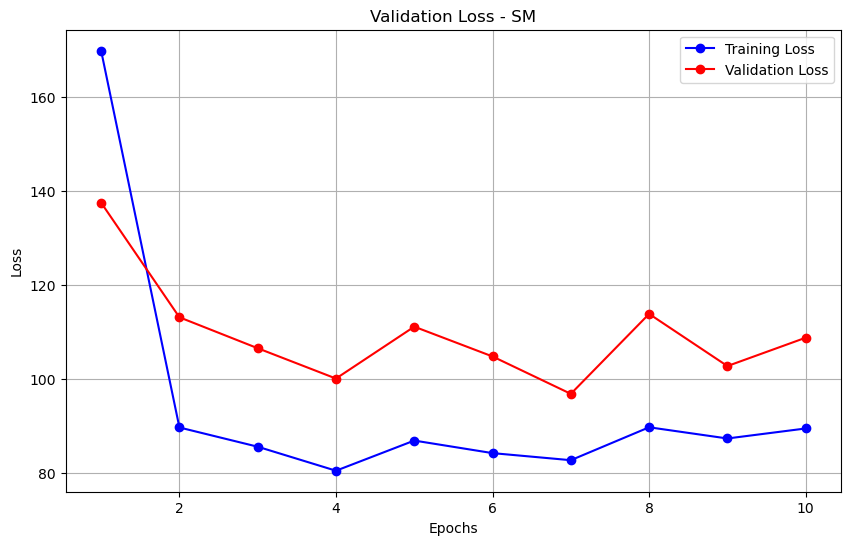

In [350]:
# import matplotlib.pyplot as plt
# Extract the loss values
train_loss = sm_metric_history['train']
val_loss = sm_metric_history['val']

# Create a list of epochs for the x-axis (e.g., [1, 2, 3, ..., 100])
lepochs = list(range(1,params_train["num_epochs"] + 1))

# Create the train and validation loss plots
plt.figure(figsize=(10, 6))
plt.plot(lepochs, train_loss, marker='o', linestyle='-', color='b', label='Training Loss')
plt.plot(lepochs, val_loss, marker='o', linestyle='-', color='r', label='Validation Loss')
plt.title('Validation Loss - SM')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

In [41]:
model.load_state_dict(torch.load(params_train["path2weights"]))

<All keys matched successfully>

In [52]:
#model= model.to('cuda:0')
#model= model.to('cpu')

In [106]:
it = iter(train_loader)

In [107]:
din, static, val = next(it)
din.shape, static.shape, val.shape

(torch.Size([256, 1461, 3]), torch.Size([256, 8]), torch.Size([256, 1461, 1]))

In [ ]:
plt.figure(figsize=(20,10)) 
plt.plot(model(din, static).detach().cpu().numpy()[101,:,0], label ="model")
plt.plot(val[101,:,0], label="val")
plt.legend()

In [42]:
from hython.utils import predict, reconstruct_from_missing, reshape_to_2Dspatial, to_xr
from hython.viz import map_bias, map_pbias, map_pearson, map_at_timesteps, ts_compare

In [43]:
yhat = predict(Xd_clean, Xs_clean, model, spatial_batch_size, device)

In [44]:
yhat = reconstruct_from_missing(
                                yhat, 
                                Y.shape,
                                idx
    )
yhat.shape

(810953, 1461, 1)

In [46]:
lat, lon, time = len(target_ds.lat), len(target_ds.lon), Y.shape[1]
lat*lon,time

(810953, 1461)

In [47]:
yhat = reshape_to_2Dspatial(
    yhat,
    lat,
    lon,
    time, 
    1)

In [48]:
y = reshape_to_2Dspatial(
    Y,
    lat,
    lon,
    time,
    1)

In [53]:
y = to_xr(y[...,0], coords = dict(target_ds.coords))
yhat = to_xr(yhat[...,0], coords = dict(target_ds.coords))

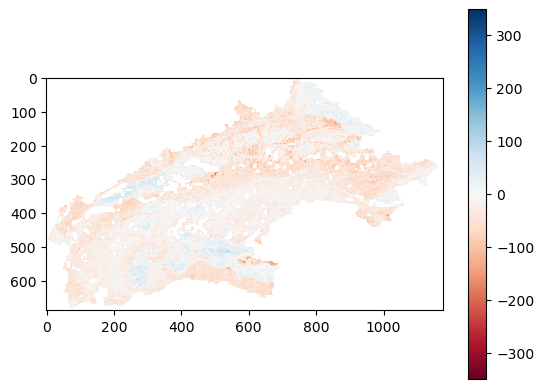

In [54]:
map_bias(y, yhat)

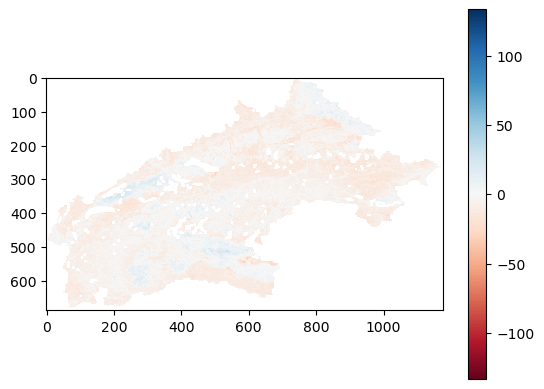

In [55]:
map_pbias(y, yhat)

In [ ]:
map_pearson(y, yhat)

In [ ]:
ts_compare(y, yhat, lat = [44.752], lon = [10.5]) # pixel on river

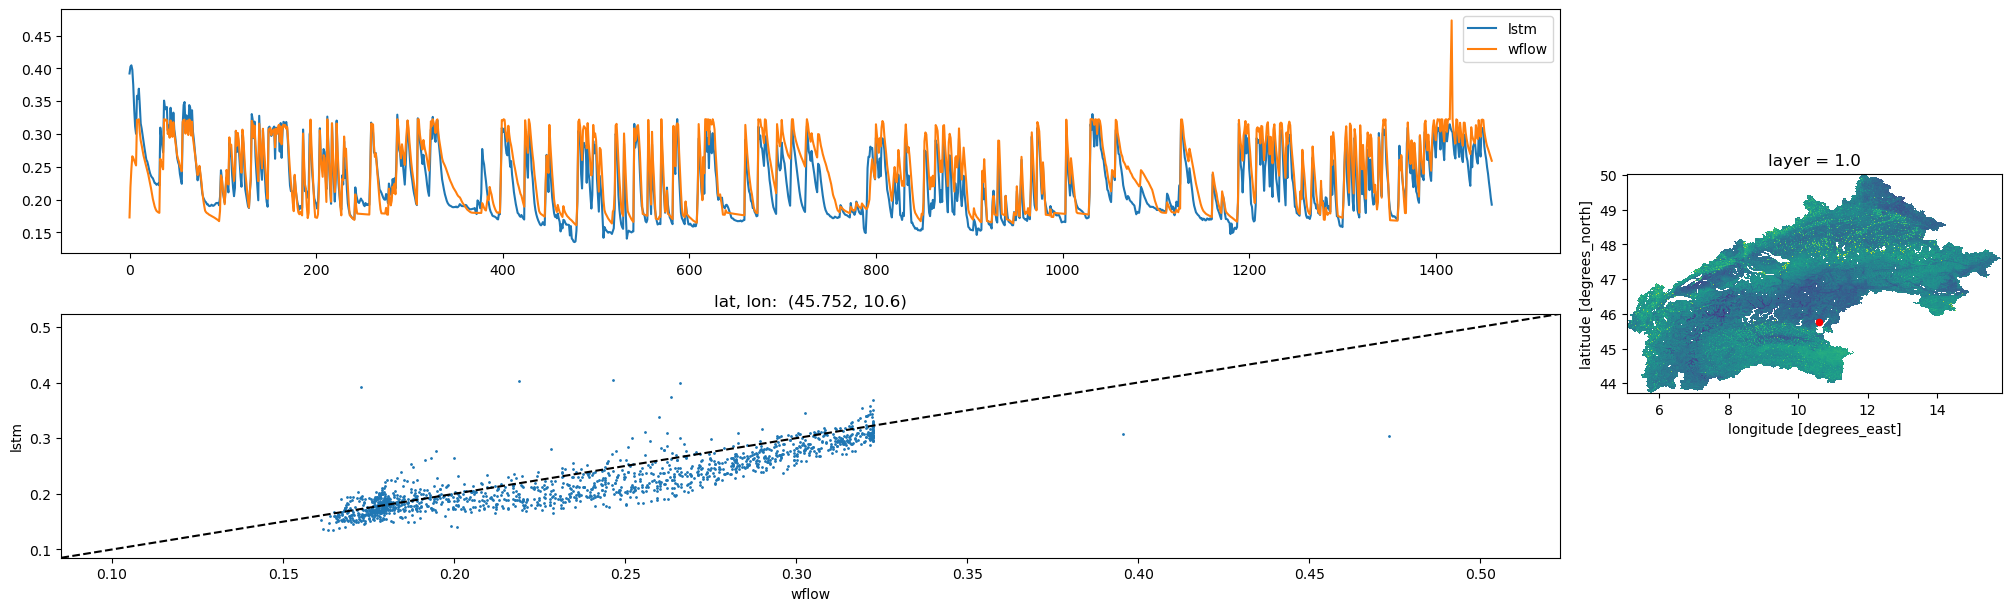

In [63]:
ts_compare(y, yhat, lat = [45.752], lon = [10.6]) 

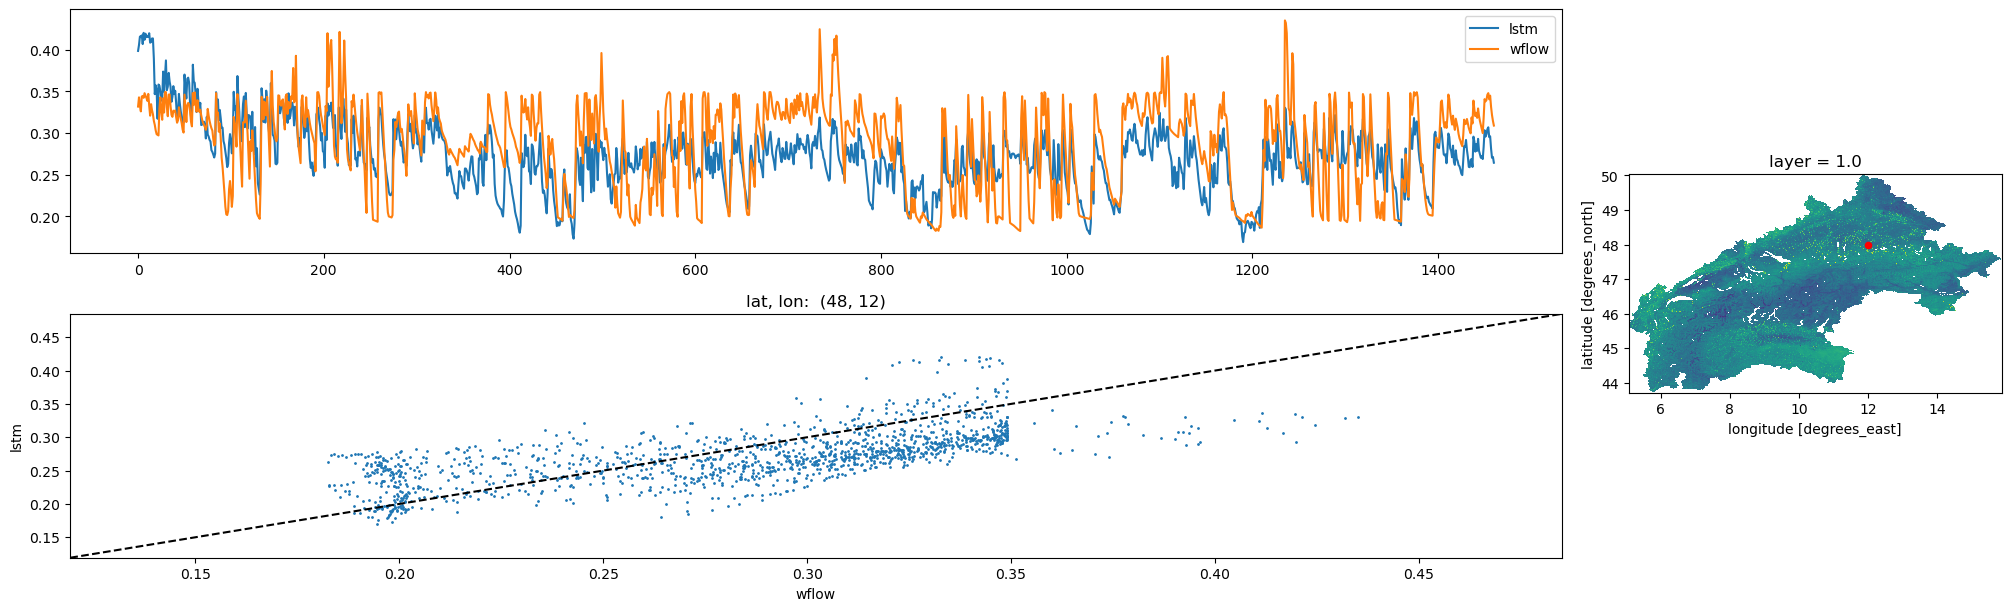

In [64]:
ts_compare(y, yhat, lat = [48], lon = [12]) 

In [ ]:
map_at_timesteps(y, yhat, dates=["2019-01-01", "2019-06-01","2019-10-01"])